In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

from math import exp
from numpy import sign

import json
import re
import ftfy
import nltk

from nltk.corpus import stopwords
from nltk import PorterStemmer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from gensim.models import KeyedVectors

from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
#Reproducibility

np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [3]:
DEPRESSIVE_TWEETS_CSV = 'DepressedTweets.csv'
RANDOM_TWEETS_CSV = 'RandomSentimentTweets.csv'
EMBEDDING_FILE = 'Model.bin'

depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [4]:
depressiveTweetsArr= [x for x in depressive_tweets_df[5]]
randomTweetsArr= [x for x in random_tweets_df['SentimentText']]
print(depressiveTweetsArr)
print(randomTweetsArr)

["The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.", "i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy", "depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.", 'Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0', '@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>', 'my anxiety an

In [8]:
# Loading Contraction List
with open('contractions.json') as f:
    clist=json.load(f)

c_re=re.compile('(%s)'%'|'.join(clist.keys()))

def expandContractions(text,c_re=c_re):
    def replace(match):
        return clist[match.group(0)]
    return c_re.sub(replace,text)

# Cleaning Tweets And Tokenizing Words
def clean_tweets(tweets):
    cleaned_tweets=[]
    for  tweet in tweets:
        tweet=str(tweet)

        if re.match("(\w+\/\/\S+)",tweet)==None and len(tweet)>10:
            tweet=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
            
            tweet=ftfy.fix_text(tweet)
            
            tweet=expandContractions(tweet)
            
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            stop_words = set(stopwords.words('english'))
            
            word_tokens = nltk.word_tokenize(tweet)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)
            tweet = PorterStemmer().stem(tweet)
            cleaned_tweets.append(tweet)
    return cleaned_tweets

cleanDepressiveTweets=clean_tweets(depressiveTweetsArr)
cleanRandomTweets=clean_tweets(randomTweetsArr)

In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(cleanDepressiveTweets + cleanRandomTweets)

sequences_d = tokenizer.texts_to_sequences(cleanDepressiveTweets)
sequences_r = tokenizer.texts_to_sequences(cleanRandomTweets)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Found 21605 unique tokens
Shape of data_d tensor: (2308, 140)
Shape of data_r tensor: (11911, 140)


In [10]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [11]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [17]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=True))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

model.save("model.bin")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [19]:
# list all data in history
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


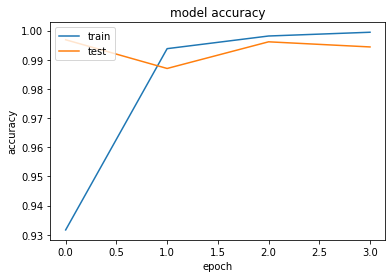

In [20]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

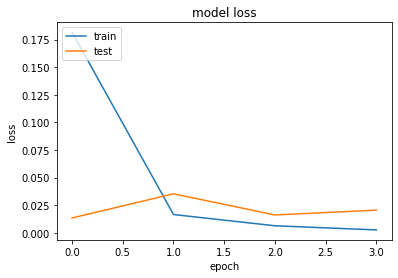

In [21]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Model test predict

labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.26%


In [23]:
# Classification report

print(len(data_test))

print(classification_report(labels_test,labels_pred)) 

print(confusion_matrix(labels_test,labels_pred))


2844
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2382
           1       0.96      1.00      0.98       462

    accuracy                           0.99      2844
   macro avg       0.98      0.99      0.99      2844
weighted avg       0.99      0.99      0.99      2844

[[2363   19]
 [   2  460]]
